In [44]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm.auto as tqdm
import math
from numba import cuda

%env KERAS_BACKEND=torch


env: KERAS_BACKEND=torch


In [45]:
# Move to project root
from pathlib import Path
import os

if not Path("./checkpoints").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "checkpoints").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./checkpoints").is_dir()

In [46]:
from src import convolutions
from src import load_data

In [47]:
@cuda.jit("void(float32[:])")
def add_one(arr):
    x = cuda.grid(1)
    if x < arr.size:
        arr[x] += 1

In [48]:
a = torch.tensor([5, 4, 3, 2], dtype=torch.float32, device="cuda")
a

tensor([5., 4., 3., 2.], device='cuda:0')

In [49]:
add_one[1, 16](a)
a

/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


tensor([6., 5., 4., 3.], device='cuda:0')

In [50]:
test_con = 1


@cuda.jit("void(float32[:, :, :, :], float32[:, :, :, :], int64, int64, int64, int64)")
def mark_channels(arr, out, bs, cs, ys, xs):
    z, y, x = cuda.grid(3)
    b, c = divmod(z, cs)
    if x < xs and y < ys and b < bs:
        out[b, c, y, x] = arr[b, c, y, x] * c + x + y + test_con

In [51]:
a = torch.randn((256, 100, 5, 5), device="cuda")
o = torch.zeros_like(a)
o.shape

torch.Size([256, 100, 5, 5])

In [52]:
tpb = (2, 8, 8)
tot_tpb = np.prod(tpb)
print("Total TPB:", tot_tpb)
assert tot_tpb < 512, tot_tpb
nbs = (
    math.ceil(a.shape[0] * a.shape[1] / tpb[0]),
    math.ceil(a.shape[-2] / tpb[-2]),
    math.ceil(a.shape[-1] / tpb[-1]),
)
n_threads = np.prod(tpb) * np.prod(nbs)
print("NBS:", nbs)
print("N_threads", n_threads)
print("Size:", a.nelement())
print(f"Thread util: {a.nelement() / n_threads:.1%}")
assert a.nelement() <= n_threads

Total TPB: 128
NBS: (12800, 1, 1)
N_threads 1638400
Size: 640000
Thread util: 39.1%


In [53]:
def run_one():
    cuda.synchronize()
    mark_channels[nbs, tpb](a, o, *a.shape)
    cuda.synchronize()


run_one()
# %timeit run_one()

In [54]:
test_con2 = 1


@cuda.jit("void(float32[:, :, :, :], float32[:, :, :, :], int64, int64, int64, int64)")
def mark_channels_flat(arr, out, _bs, cs, ys, xs):
    idx = cuda.grid(1)
    if idx >= arr.size:
        return
    idx_y, x = divmod(idx, xs)
    idx_z, y = divmod(idx_y, ys)
    b, c = divmod(idx_z, cs)
    # if x < xs and y < ys and b < bs:
    out[b, c, y, x] = arr[b, c, y, x] * c + x + y + test_con2

In [55]:
o[:] = 0
mark_channels_flat[math.ceil(a.nelement() / 32), 32](a, o, *a.shape)

In [56]:
o[:] = 0
mark_channels[nbs, tpb](a, o, *a.shape)

In [57]:
def run_one():
    cuda.synchronize()
    mark_channels_flat[math.ceil(a.nelement() / 256), 256](a, o, *a.shape)
    cuda.synchronize()


run_one()
# %timeit run_one()

In [58]:
print(o[10, 2])

tensor([[1.0075, 0.9014, 1.8817, 4.3399, 1.6510],
        [1.2098, 0.9147, 7.8809, 6.0232, 5.5381],
        [2.8508, 7.7282, 5.1394, 6.9000, 6.1162],
        [2.1453, 1.8389, 6.9852, 9.8757, 5.6861],
        [5.3201, 7.8816, 6.2774, 9.4658, 7.8020]], device='cuda:0')


In [59]:
reduce_max = True
INF = float("inf")


@cuda.jit(
    "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
    " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X
    " float32[:, :, :, :],"  # out_img: [Batch, Channel, Img_Y, Img_X]
    " int16[:, :, :, :, :],"  # out_prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
    " int64,"  # Channels
    " int64, int64,"  # Img_Y, Img_X
    " int64, int64)",  # Kernel_Y, Kernel_X
    debug=True,
    opt=False,
)
def dilate_flat(img, kernel, out_img, out_prov, cs, i_ys, i_xs, k_ys, k_xs):
    idx = cuda.grid(1)
    if idx >= img.size:
        return
    idx_y, centre_x = divmod(idx, i_xs)
    idx_z, centre_y = divmod(idx_y, i_ys)
    b, c = divmod(idx_z, cs)

    top_y, left_x = centre_y - k_ys // 2, centre_x - k_xs // 2
    best_x = best_y = -99
    best_val = -INF if reduce_max else INF

    for k_y, i_y in enumerate(range(top_y, top_y + k_ys)):
        for k_x, i_x in enumerate(range(left_x, left_x + k_xs)):
            if i_x < 0 or i_x > i_xs or i_y < 0 or i_y > i_ys:
                continue

            if reduce_max:
                val = img[b, c, i_y, i_x] + kernel[c, k_y, k_x]
                if val > best_val:
                    best_y, best_x = i_y, i_x
                    best_val = val
            else:
                val = img[b, c, i_y, i_x] - kernel[c, k_y, k_x]
                if val < best_val:
                    best_y, best_x = i_y, i_x
                    best_val = val

    out_img[b, c, centre_y, centre_x] = best_val
    out_prov[b, c, centre_y, centre_x, 0] = best_y
    out_prov[b, c, centre_y, centre_x, 1] = best_x

/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/core/lowering.py:116: NumbaDebugInfoWarning: Could not find source for function: <function dilate_flat at 0x7b16ac0e8220>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))


In [60]:
mnist = load_data.mnist()

normalisation: tensor([[[33.3184]]]) tensor([[[78.5675]]])


In [61]:
test_imgs = (
    torch.asarray(mnist.x_train[:2048], device="cuda").unsqueeze(1).repeat((1, 6, 1, 1))
)
print(test_imgs.dtype)
test_imgs.shape

torch.float32


torch.Size([2048, 6, 28, 28])

In [62]:
test_kernels = -torch.asarray(
    [
        # 1: Does nothing
        [[[INF, INF, INF], [INF, 0, INF], [INF, INF, INF]]],
        # 2: Vertical max
        [[[INF, 0, INF], [INF, 0, INF], [INF, 0, INF]]],
        # 3: Horizontal max
        [[[INF, INF, INF], [0, 0, 0], [INF, INF, INF]]],
        # 4: 3x3 max
        [[[0, 0, 0], [0, 0, 0], [0, 0, 0]]],
        # 5: small quadratic max, isotropic
        [[[0.4, 0.1, 0.4], [0.1, 0, 0.1], [0.4, 0.1, 0.4]]],
        # 6: small quadratic max, wide horizontally
        [[[0.5, 0.2, 0.5], [0.05, 0, 0.05], [0.5, 0.2, 0.5]]],
    ],
    device="cuda",
).squeeze(1)
print(test_kernels.dtype)
test_kernels.shape

torch.float32


torch.Size([6, 3, 3])

In [63]:
o_i = torch.full_like(test_imgs, -700, device="cuda")
o_p = torch.full(test_imgs.shape + (2,), -699, dtype=torch.int16, device="cuda")

In [64]:
o_i[:] = -688
o_p[:] = -689
dilate_flat[math.ceil(test_imgs.nelement() / 256), 256](
    test_imgs, test_kernels, o_i, o_p, *test_imgs.shape[1:], *test_kernels.shape[1:]
)

In [65]:
def compile_tropical_conv(
        is_max: bool,
        channels: int,
        kernel_size: int,
        block_size: int = 256,
        debug: bool = False,
        calculate_prov: bool = True,
):
    cs = channels
    k_ys = k_xs = kernel_size

    @cuda.jit(
        "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X
        " float32[:, :, :, :],"  # out_img: [Batch, Channel, Img_Y, Img_X]
        f"{'int16[:, :, :, :, :],' if calculate_prov else 'int16,'}"  # out_prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
        " int64, int64)",  # Img_Y, Img_X
        debug=debug,
        opt=not debug,
    )
    def conv_cuda(img, kernel, out_img, out_prov, i_ys, i_xs):
        idx = cuda.grid(1)
        if idx >= img.size:
            return
        idx_y, centre_x = divmod(idx, i_xs)
        idx_z, centre_y = divmod(idx_y, i_ys)
        b, c = divmod(idx_z, cs)

        top_y, left_x = centre_y - k_ys // 2, centre_x - k_xs // 2
        best_x = best_y = -99
        best_val = -INF if is_max else INF

        for k_y, i_y in enumerate(range(top_y, top_y + k_ys)):
            for k_x, i_x in enumerate(range(left_x, left_x + k_xs)):
                if i_x < 0 or i_x >= i_xs or i_y < 0 or i_y >= i_ys:
                    continue

                if is_max:
                    val = img[b, c, i_y, i_x] + kernel[c, k_y, k_x]
                    if val > best_val:
                        best_val = val
                        if calculate_prov:
                            best_y, best_x = i_y, i_x
                else:
                    val = img[b, c, i_y, i_x] - kernel[c, k_y, k_x]
                    if val < best_val:
                        best_val = val
                        if calculate_prov:
                            best_y, best_x = i_y, i_x

        out_img[b, c, centre_y, centre_x] = best_val
        if calculate_prov:
            out_prov[b, c, centre_y, centre_x, 0] = best_y
            out_prov[b, c, centre_y, centre_x, 1] = best_x

    def conv(img: torch.Tensor, kernel: torch.Tensor):
        img, kernel = img.detach(), kernel.detach()
        out_img = torch.empty_like(img)
        if calculate_prov:
            out_prov = torch.empty(
                img.shape + (2,), device=img.device, dtype=torch.int16
            )
        else:
            out_prov = -1
        n_blocks = math.ceil(img.nelement() / block_size)
        conv_cuda[n_blocks, block_size](
            img, kernel, out_img, out_prov, img.shape[2], img.shape[3]
        )
        if calculate_prov:
            return out_img, out_prov
        return out_img

    return conv

In [66]:
max_op = compile_tropical_conv(is_max=True, channels=6, kernel_size=3)
min_op = compile_tropical_conv(is_max=False, channels=6, kernel_size=3)

<Figure size 640x480 with 0 Axes>

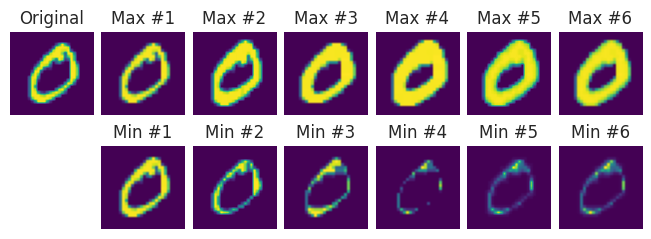

In [67]:
img_num = 1
plt.set_cmap("viridis")
_, ((ax_original, *ax_maxs), (ax_unused, *ax_mins)) = plt.subplots(
    2, 1 + 6, layout="compressed"
)
ax_original.set_axis_off()
ax_unused.set_axis_off()
ax_original.imshow(test_imgs[img_num, 0].numpy(force=True))
ax_original.set_title("Original")
max_imgs = max_op(test_imgs, test_kernels)[0]
for i, (ax, img_channel) in enumerate(
        zip(ax_maxs, max_imgs[img_num].numpy(force=True), strict=True), 1
):
    ax.set_axis_off()
    ax.imshow(img_channel)
    ax.set_title(f"Max #{i}")
min_imgs = min_op(test_imgs, test_kernels)[0]
for i, (ax, img_channel) in enumerate(
        zip(ax_mins, min_imgs[img_num].numpy(force=True), strict=True), 1
):
    ax.set_axis_off()
    ax.imshow(img_channel)
    ax.set_title(f"Min #{i}")
plt.show()

In [68]:
unfold_max = convolutions.TropicalConv2D(is_max=True)

In [69]:
def run_one():
    torch.cuda.synchronize()
    arr = unfold_max(test_imgs, test_kernels.unsqueeze(1))[0]
    del arr
    torch.cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()

In [70]:
per_img_shape = test_imgs.shape[2:]
print(per_img_shape)
np.prod(per_img_shape)

torch.Size([28, 28])


np.int64(784)

In [71]:
per_image_max_op = compile_tropical_conv(
    is_max=True, channels=6, kernel_size=3, block_size=784
)


def run_one():
    cuda.synchronize()
    arr = max_op(test_imgs, test_kernels)[0]
    del arr
    cuda.synchronize()


def run_one_per_image():
    cuda.synchronize()
    arr = per_image_max_op(test_imgs, test_kernels)[0]
    del arr
    cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()
run_one_per_image()
# %timeit run_one_per_image()
torch.cuda.empty_cache()

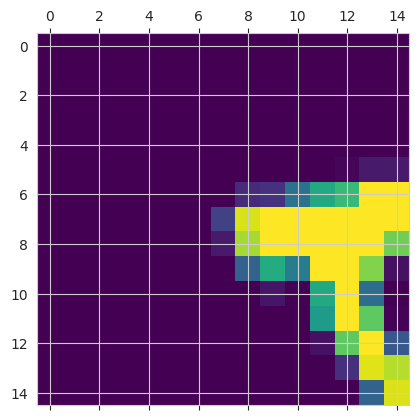

In [72]:
plt.matshow(test_imgs[0, 0, :15, :15].numpy(force=True))

In [73]:
import importlib

importlib.reload(convolutions)
from src import convolutions

Nonzero gradient in image: (array([6, 6, 7, 8]), array([8, 9, 8, 8]))


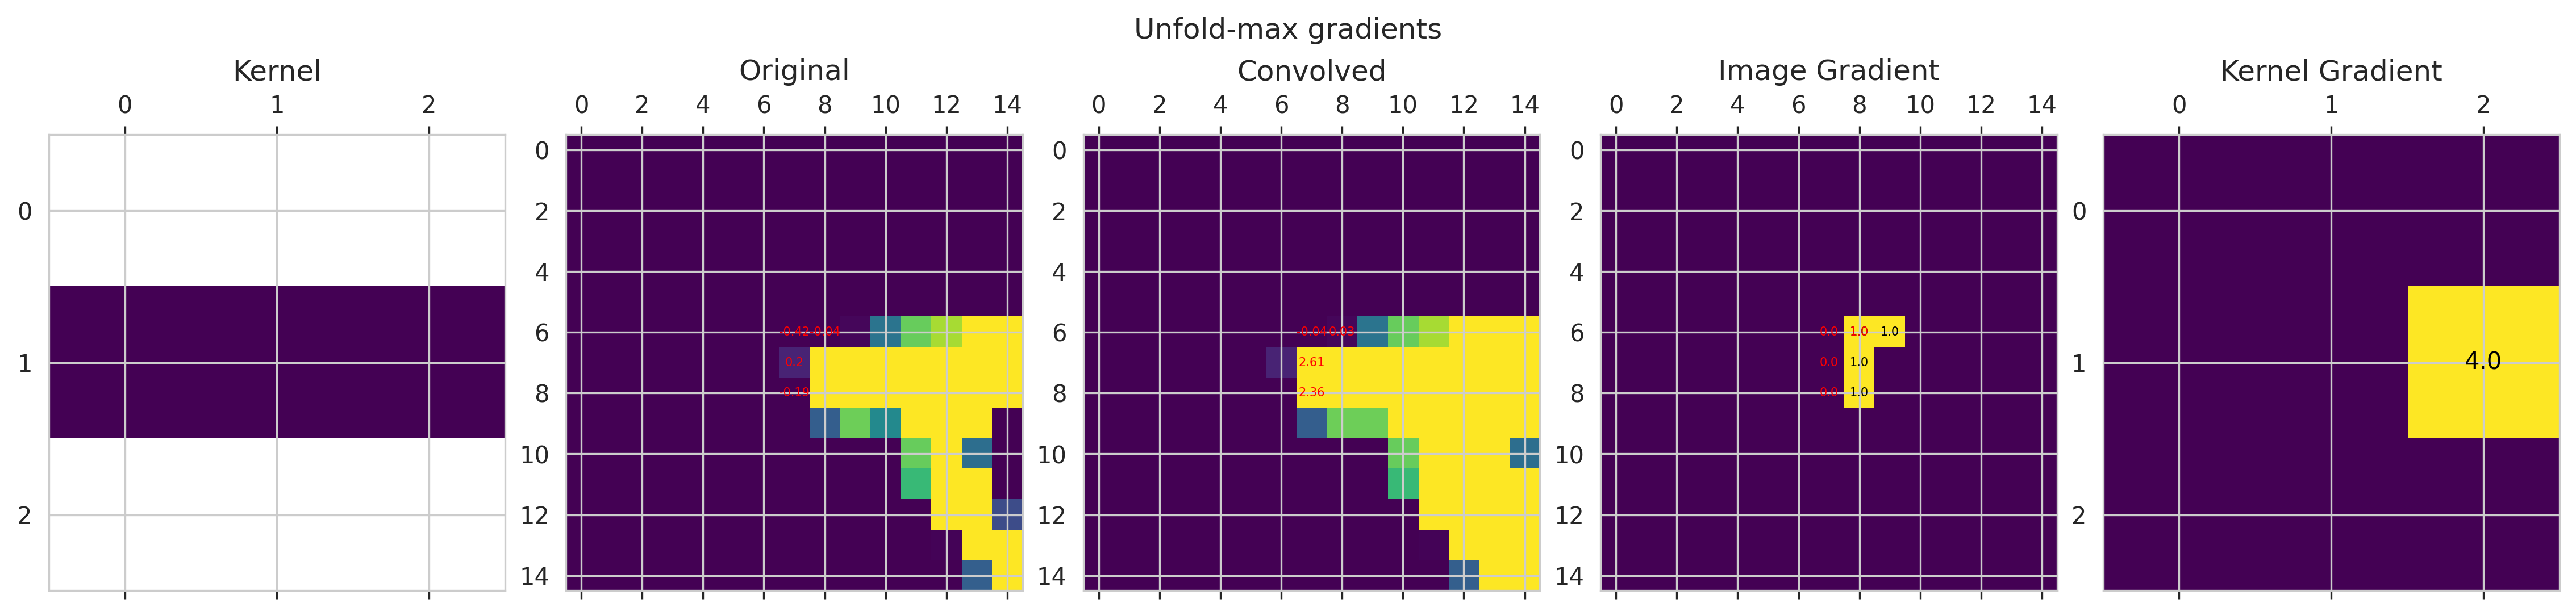

In [74]:
channel_nr = 2
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
# g_imgs[0, channel_nr, 7, 7] *= 100
g_imgs.requires_grad_(True)
g_kernels.requires_grad_(True)
g_imgs.grad = None
g_kernels.grad = None

x_slice = slice(None, 15)
y_slice = slice(None, 15)
target_xs = [7, 7, 7, 8]
target_ys = [6, 7, 8, 6]
target_x = target_y = None
res_imgs = convolutions.TropicalConv2D(is_max=True)(
    g_imgs, g_kernels.unsqueeze(1), padding=1
)
res_imgs[0, channel_nr, target_ys, target_xs].sum().backward()
_, axs = plt.subplots(ncols=5, layout="compressed", figsize=(15, 15), dpi=300)

axs[0].matshow(g_kernels[channel_nr].numpy(force=True))
axs[0].set_title("Kernel")
axs[1].matshow(
    g_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[1].set_title("Original")
axs[2].matshow(
    res_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[2].set_title("Convolved")
g_np = g_imgs.grad[0, channel_nr, y_slice, x_slice].numpy(force=True)
axs[3].matshow(g_np)
axs[3].set_title("Image Gradient")
g_np_k = g_kernels.grad[channel_nr].numpy(force=True)
axs[4].matshow(g_np_k)
axs[4].set_title("Kernel Gradient")
for g_i, g_j in zip(*g_np.nonzero()):
    axs[3].text(
        g_j, g_i, g_np[g_i, g_j], color="black", fontsize=5, ha="center", va="center"
    )
for g_i, g_j in zip(*g_np_k.nonzero()):
    axs[4].text(
        g_j, g_i, g_np_k[g_i, g_j], color="black", fontsize=10, ha="center", va="center"
    )
for ax, ax_arr in zip(axs[1:4], (g_imgs, res_imgs, g_imgs.grad)):
    for tx, ty in zip(target_xs, target_ys):
        ax.text(
            tx,
            ty,
            ax_arr[0, channel_nr, ty, tx].numpy(force=True).round(2),
            color="red",
            fontsize=5,
            ha="center",
            va="center",
        )
    # ax.scatter(target_x, target_y, marker="x", color='red')
plt.suptitle("Unfold-max gradients")
print("Nonzero gradient in image:", g_np.nonzero())

In [75]:
def compile_tropical_conv_backwards(
        is_max: bool,
        channels: int,
        kernel_size: int,
        block_size: int = 256,
        debug: bool = False,
):
    def one(v, w):
        return 1

    def minus_one(v, w):
        return -1

    cs = channels
    k_ys = k_xs = kernel_size
    if is_max:
        d_weigh_d_v = d_weigh_d_w = one
    else:
        d_weigh_d_v = one
        d_weigh_d_w = minus_one

    d_weigh_d_v = cuda.jit(d_weigh_d_v, device=True)
    d_weigh_d_w = cuda.jit(d_weigh_d_w, device=True)

    # noinspection PyArgumentList
    @cuda.jit(
        "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X]
        " float32[:, :, :, :],"  # res_tangent: [Batch, Channel, Img_Y, Img_X]
        " int16[:, :, :, :, :],"  # res_prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
        " float32[:, :, :, :],"  # out_img_grad: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # out_kernel_grad: [Channel, Kernel_Y, Kernel_X]
        " int64, int64)",  # Img_Y, Img_X
        debug=debug,
        opt=not debug,
    )
    def conv_backwards_cuda(
            img, kernel, res_tangent, res_prov, out_img_grad, out_kernel_grad, i_ys, i_xs
    ):
        idx = cuda.grid(1)
        if idx >= img.size:
            return
        idx_y, centre_x = divmod(idx, i_xs)
        idx_z, centre_y = divmod(idx_y, i_ys)
        b, c = divmod(idx_z, cs)
        tangent = res_tangent[b, c, centre_y, centre_x]
        if tangent == 0:
            return

        i_prov_x, i_prov_y = (
            res_prov[b, c, centre_y, centre_x, 1],
            res_prov[b, c, centre_y, centre_x, 0],
        )
        img_val = img[b, c, i_prov_y, i_prov_x]

        rel_prov_x, rel_prov_y = i_prov_x - centre_x, i_prov_y - centre_y
        k_prov_x, k_prov_y = rel_prov_x + k_xs // 2, rel_prov_y + k_ys // 2
        kernel_val = kernel[c, k_prov_y, k_prov_x]

        dv = d_weigh_d_v(img_val, kernel_val) * tangent
        dw = d_weigh_d_w(img_val, kernel_val) * tangent

        cuda.atomic.add(out_img_grad, (b, c, i_prov_y, i_prov_x), dv)
        cuda.atomic.add(out_kernel_grad, (c, k_prov_y, k_prov_x), dw)

    def backwards(
            img: torch.Tensor,
            kernel: torch.Tensor,
            res_tangent: torch.Tensor,
            res_prov: torch.Tensor,
    ):
        img, kernel = img.detach(), kernel.detach()
        out_img_grad = torch.zeros_like(img)
        out_kernel_grad = torch.zeros_like(kernel)
        n_blocks = math.ceil(img.nelement() / block_size)
        conv_backwards_cuda[n_blocks, block_size](
            img,
            kernel,
            res_tangent,
            res_prov,
            out_img_grad,
            out_kernel_grad,
            img.shape[2],
            img.shape[3],
        )
        return out_img_grad, out_kernel_grad

    return backwards

In [76]:
max_back_op = compile_tropical_conv_backwards(is_max=True, channels=6, kernel_size=3)

Nonzero gradient in image: (array([6, 6, 7, 8]), array([8, 9, 8, 8]))


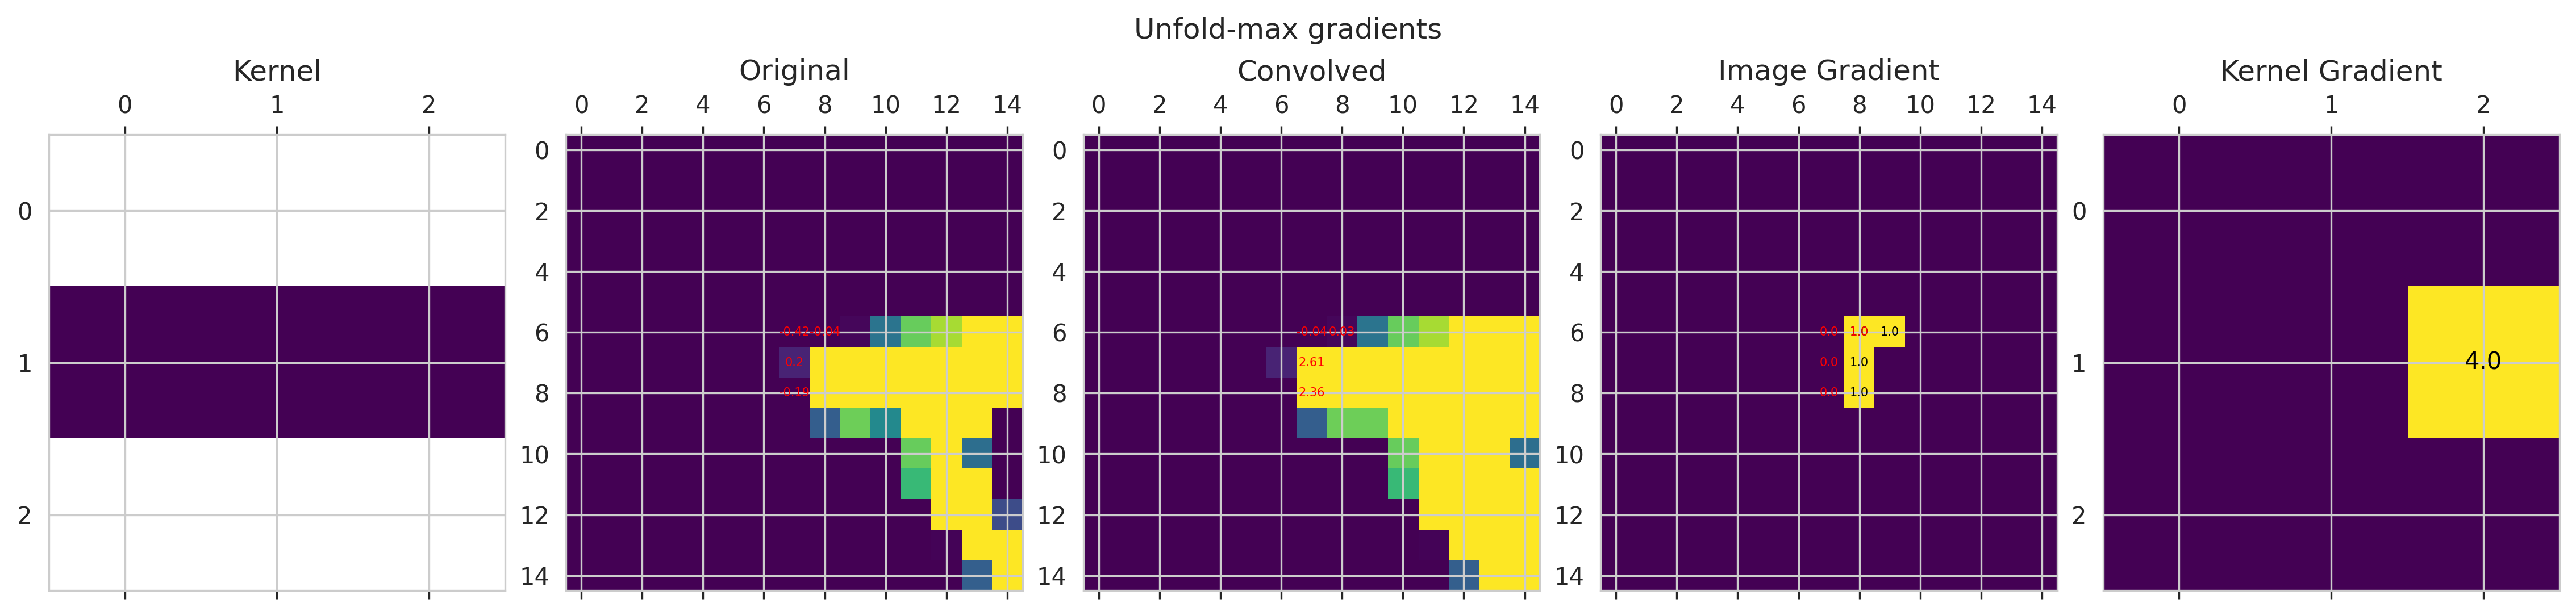

In [77]:
channel_nr = 2
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
# g_imgs[0, channel_nr, 7, 7] *= 100

x_slice = slice(None, 15)
y_slice = slice(None, 15)
target_xs = [7, 7, 7, 8]
target_ys = [6, 7, 8, 6]
target_x = target_y = None
res_imgs, test_provs = max_op(g_imgs, g_kernels)
test_tangent = torch.zeros_like(res_imgs)
test_tangent[0, channel_nr, target_ys, target_xs] = 1
test_i_grad, test_k_grad = max_back_op(g_imgs, g_kernels, test_tangent, test_provs)

_, axs = plt.subplots(ncols=5, layout="compressed", figsize=(15, 15), dpi=300)
axs[0].matshow(g_kernels[channel_nr].numpy(force=True))
axs[0].set_title("Kernel")
axs[1].matshow(
    g_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[1].set_title("Original")
axs[2].matshow(
    res_imgs[0, channel_nr, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
)
axs[2].set_title("Convolved")
g_np = test_i_grad[0, channel_nr, y_slice, x_slice].numpy(force=True)
axs[3].matshow(g_np)
axs[3].set_title("Image Gradient")
g_np_k = test_k_grad[channel_nr].numpy(force=True)
axs[4].matshow(g_np_k)
axs[4].set_title("Kernel Gradient")
for g_i, g_j in zip(*g_np.nonzero()):
    axs[3].text(
        g_j, g_i, g_np[g_i, g_j], color="black", fontsize=5, ha="center", va="center"
    )
for g_i, g_j in zip(*g_np_k.nonzero()):
    axs[4].text(
        g_j, g_i, g_np_k[g_i, g_j], color="black", fontsize=10, ha="center", va="center"
    )
for ax, ax_arr in zip(axs[1:4], (g_imgs, res_imgs, test_i_grad)):
    for tx, ty in zip(target_xs, target_ys):
        ax.text(
            tx,
            ty,
            ax_arr[0, channel_nr, ty, tx].numpy(force=True).round(2),
            color="red",
            fontsize=5,
            ha="center",
            va="center",
        )
    # ax.scatter(target_x, target_y, marker="x", color='red')
plt.suptitle("Unfold-max gradients")
print("Nonzero gradient in image:", g_np.nonzero())

In [78]:
test_tangent_dense = torch.randn_like(test_imgs)

In [79]:
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
g_imgs.requires_grad_(True)
g_kernels.requires_grad_(True)


def run_one():
    torch.cuda.synchronize()
    arr = unfold_max(g_imgs, g_kernels.unsqueeze(1), padding=1)
    arr.backward(test_tangent_dense)
    del arr
    torch.cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()

In [80]:
# @torch.compile
def run_one():
    cuda.synchronize()
    arr, provs = max_op(test_imgs, test_kernels)
    i_grad, k_grad = max_back_op(test_imgs, test_kernels, test_tangent_dense, provs)
    del arr, i_grad, k_grad
    cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()

In [81]:
plt.set_cmap("viridis");

<Figure size 640x480 with 0 Axes>

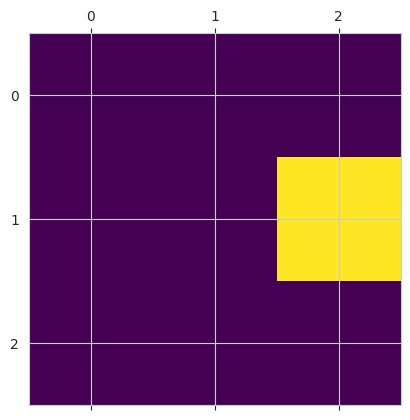

In [82]:
@torch.library.custom_op("semifields::dilation", mutates_args={}, device_types="cuda")
def lib_max_op(
        img: torch.Tensor,
        kernel: torch.Tensor,
        padding: int = 1,
        stride: int = 1,
        dilation: int = 1,
) -> tuple[torch.Tensor, torch.Tensor]:
    return max_op(img, kernel)


@lib_max_op.register_fake
def _(img: torch.Tensor, kernel, padding: int = 1, stride: int = 1, dilation: int = 1):
    assert img.dtype == torch.float32
    assert kernel.dtype == torch.float32
    assert padding == 1
    assert stride == 1
    assert dilation == 1
    return torch.empty_like(img), img.new_empty(img.shape + (2,), dtype=torch.int16)


def _back_setup(ctx, inputs, output):
    img, kernel, padding, stride, dilation = inputs
    _res, prov = output
    ctx.img = img
    ctx.kernel = kernel
    ctx.prov = prov


@torch.library.custom_op(
    "semifields::dilation_back", mutates_args={}, device_types="cuda"
)
def _lib_back_op(
        img: torch.Tensor, kernel: torch.Tensor, tangent: torch.Tensor, prov: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    grad_img, grad_kernel = max_back_op(img, kernel, tangent, prov)
    return grad_img, grad_kernel


@_lib_back_op.register_fake
def _(img, kernel, _tangent, _prov):
    assert img.dtype == torch.float32
    assert kernel.dtype == torch.float32
    assert _tangent.dtype == torch.float32
    assert _prov.dtype == torch.int16
    return torch.empty_like(img), torch.empty_like(kernel)


def _lib_back(ctx, grad_output, _grad_prov):
    return _lib_back_op(ctx.img, ctx.kernel, grad_output, ctx.prov)


lib_max_op.register_autograd(_lib_back, setup_context=_back_setup)

g_kernels.grad = None
g_kernels.requires_grad_(True)
test_tangent = torch.zeros_like(test_imgs)
test_tangent[0, channel_nr, target_ys, target_xs] = 1
lib_max_op(test_imgs, g_kernels)[0].backward(test_tangent)
# TestMaxOp.apply(test_imgs, g_kernels).backward(test_tangent)
plt.matshow(g_kernels.grad[channel_nr].numpy(force=True))

In [83]:
def numba_max(
        img: torch.Tensor,
        kernel: torch.Tensor,
        padding: int = 1,
        stride: int = 1,
        dilation: int = 1,
):
    if len(kernel.shape) == 4:
        kernel = kernel.unsqueeze(1)
    assert img.shape[1] == kernel.shape[0]
    return lib_max_op(img, kernel, padding, stride, dilation)[0]

In [84]:
test_tangent.nonzero().numpy(force=True)

array([[0, 2, 6, 7],
       [0, 2, 6, 8],
       [0, 2, 7, 7],
       [0, 2, 8, 7]])

In [85]:
lib_max_op(test_imgs, g_kernels)
# noinspection PyTypeChecker
torch.library.opcheck(lib_max_op, (test_imgs, g_kernels))

{'test_schema': 'SUCCESS',
 'test_autograd_registration': 'SUCCESS',
 'test_faketensor': 'SUCCESS',
 'test_aot_dispatch_dynamic': 'SUCCESS'}

In [86]:
# it doesn't pass gradcheck...
torch.autograd.gradcheck(lib_max_op, (test_imgs[:1], g_kernels), raise_exception=False)

/home/peter/Thesis/.venv/lib/python3.12/site-packages/torch/autograd/gradcheck.py:923: UserWarning: Input #1 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  warnings.warn(
/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 19 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


False

In [87]:
# but I don't override any gradient calculations here, so it must be down to PyTorch messing up the max/min gradients
torch.autograd.gradcheck(
    convolutions.TropicalConv2D(is_max=True),
    (test_imgs[:1], g_kernels.unsqueeze(1)),
    raise_exception=False,
)

False

In [88]:
@torch.compile(mode="reduce-overhead")
def run_one():
    cuda.synchronize()
    arr, provs = lib_max_op(test_imgs, g_kernels)
    arr.backward(test_tangent_dense)
    del arr
    cuda.synchronize()


torch.cuda.empty_cache()
run_one()
# %timeit run_one()
torch.cuda.empty_cache()

In [89]:
from timeit import timeit
from tqdm.auto import tqdm, trange

In [90]:
# fmt: off
slice_sizes = [2, 3, 4, 6, 8, 12, 16, 23, 32, 46, 64, 91, 128, 182, 256, 363, 512, 725, 1024, 1449, 2048]
unfold_timings = [0.00010274730650053243, 8.403245400040759e-05, 8.851143950232653e-05, 0.00010076602150002145,
                  0.00012131676400167635, 0.000124929585501377, 0.00014966875500249443, 0.000199354405496706,
                  0.00025833106350182786, 0.00035760370749994764, 0.0004823765924993495, 0.0006648011590004899,
                  0.0009164136265026173, 0.001269442678501946, 0.0017770433570003662, 0.0025119446479984616,
                  0.0036233893550015636, 0.0052635354004996774, 0.007498402453999006, 0.010653741374000674,
                  0.014994164466501389]
numba_timings = [0.00041991026799951213, 0.0004150625224974647, 0.00041995406449859727, 0.0004226304935000371,
                 0.0004205896764979116, 0.0004200762550026411, 0.00042519056650053245, 0.00043969415899846356,
                 0.000461269485498633, 0.0004921157089993358, 0.0005326687759988999, 0.000598328826999932,
                 0.0006867694915017637, 0.0008550973589990463, 0.0010212399034971896, 0.0012820430794999993,
                 0.0016308881609984381, 0.00213099660050284, 0.002836544132500421, 0.0040347791409985805,
                 0.0056132207165028375]
slice_sizes_detail = [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
unfold_timings_detail = [0.0005231618008999794, 0.0005300874041199859, 0.0005373257529799594, 0.000543491658839921,
                         0.0005501257682598953, 0.0005600170065599377, 0.0005661544485400373, 0.0005724291121000715,
                         0.0005786100002999592, 0.0005850134414200147, 0.0005919706213800236, 0.0005975213742800406,
                         0.0006039276255598815, 0.0006115772961400217, 0.0006184966304400586, 0.000624261617519951,
                         0.0006320271702000172, 0.0006411902578199806, 0.0006466227984400757, 0.0006526624815800461]
numba_timings_detail = [0.0005487732924800366, 0.0005504305595999176, 0.0005602229583999724, 0.0005519845550401078,
                        0.0005552577408599609, 0.0005599274011599482, 0.0005594913014999475, 0.000562018028760067,
                        0.0005715560740999354, 0.000603191901879909, 0.0005728149966799538, 0.0006106505254599324,
                        0.0005787932900199667, 0.0005814040630200179, 0.0005867868537201139, 0.0005937331920399446,
                        0.0006245092738600214, 0.0005905518150200078, 0.000597254317360057, 0.0005953584205200604]
# fmt: on

In [91]:
run_timings = False

In [92]:
if run_timings:
    torch_code = """
sync()
arr = dilate(imgs, kernels, padding=1)
arr.backward(tangent)
del arr
sync()
    """
    slice_sizes = []
    unfold_timings = []
    numba_timings = []
    num_loops = 2_000
    bar = trange(2, 23)
    for size_pow in bar:
        test_size = math.ceil(2 ** (size_pow / 2))
        test_slice = test_imgs[:test_size]
        slice_sizes.append(len(test_slice))
        unfold_timings.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": torch.cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.unsqueeze(1).clone().requires_grad_(True),
                    "tangent": torch.randn_like(test_slice),
                    "dilate": unfold_max,
                },
            )
            / num_loops
        )
        numba_timings.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.clone().requires_grad_(True),
                    "tangent": torch.randn_like(test_slice),
                    "dilate": numba_max,
                },
            )
            / num_loops
        )
        bar.set_postfix(
            size=slice_sizes[-1],
            faster="unfold" if unfold_timings[-1] < numba_timings[-1] else "numba",
        )

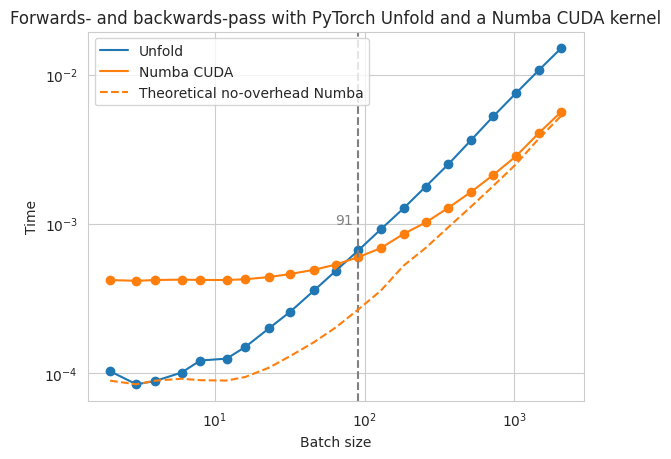

In [93]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.plot(slice_sizes, unfold_timings, label="Unfold", color=colors[0])
plt.scatter(slice_sizes, unfold_timings, color=colors[0])
plt.plot(slice_sizes, numba_timings, label="Numba CUDA", color=colors[1])
plt.scatter(slice_sizes, numba_timings, color=colors[1])
first_better = (np.subtract(unfold_timings, numba_timings) > 0).argmax()
plt.axvline(slice_sizes[first_better], linestyle="dashed", color="grey")
plt.text(slice_sizes[first_better - 1], 10 ** -3, slice_sizes[first_better], color="grey")
adjusted_numba = np.asarray(numba_timings) - numba_timings[1] + unfold_timings[1]
plt.plot(
    slice_sizes,
    adjusted_numba,
    label="Theoretical no-overhead Numba",
    linestyle="dashed",
    color=colors[1],
)
plt.xlabel("Batch size")
plt.ylabel("Time")
plt.title("Forwards- and backwards-pass with PyTorch Unfold and a Numba CUDA kernel")
plt.loglog()
plt.legend()
plt.show()

In [94]:
if run_timings:
    torch_code = """
sync()
arr = dilate(imgs, kernels, padding=1)
arr.backward(tangent)
del arr
sync()
    """
    slice_sizes_detail = []
    unfold_timings_detail = []
    numba_timings_detail = []
    num_loops = 50_000
    bar = trange(70, 90)
    test_tangent = torch.randn_like(test_imgs)
    for test_size in bar:
        test_slice = test_imgs[:test_size]
        slice_sizes_detail.append(len(test_slice))
        unfold_timings_detail.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": torch.cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.unsqueeze(1).clone().requires_grad_(True),
                    "tangent": test_tangent[:test_size],
                    "dilate": unfold_max,
                },
            )
            / num_loops
        )
        numba_timings_detail.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.clone().requires_grad_(True),
                    "tangent": test_tangent[:test_size],
                    "dilate": numba_max,
                },
            )
            / num_loops
        )
        bar.set_postfix(
            size=slice_sizes_detail[-1],
            faster="unfold"
            if unfold_timings_detail[-1] < numba_timings_detail[-1]
            else "numba",
        )

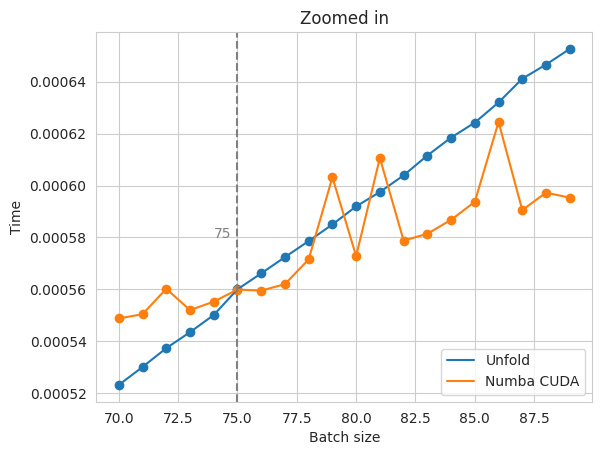

In [95]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.plot(slice_sizes_detail, unfold_timings_detail, label="Unfold", color=colors[0])
plt.scatter(slice_sizes_detail, unfold_timings_detail, color=colors[0])
plt.plot(slice_sizes_detail, numba_timings_detail, label="Numba CUDA", color=colors[1])
plt.scatter(slice_sizes_detail, numba_timings_detail, color=colors[1])
first_better = (np.subtract(unfold_timings_detail, numba_timings_detail) > 0).argmax()
plt.axvline(slice_sizes_detail[first_better], linestyle="dashed", color="grey")
plt.text(
    slice_sizes_detail[first_better - 1],
    0.00058,
    slice_sizes_detail[first_better],
    color="grey",
)
adjusted_numba = (
        np.asarray(numba_timings_detail)
        - numba_timings_detail[1]
        + unfold_timings_detail[1]
)
plt.xlabel("Batch size")
plt.ylabel("Time")
plt.title("Zoomed in")
plt.legend()
plt.show()

In [96]:
import warnings
import numba

warnings.simplefilter("ignore", numba.NumbaPerformanceWarning, 536)

In [97]:
def _conv_output_size(
        input_size: int, kernel_size: int, stride: int, padding: int, dilation: int
):
    return math.floor(
        (input_size + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
    )

In [133]:
import typing


class Foo(typing.NamedTuple):
    bar: float


ree = Foo(279.0)


def rawr(x):
    return x * 2


@cuda.jit("void(float32[:])", lineinfo=False)
def spam(arr):
    x = cuda.grid(1)
    if x < arr.size:
        arr[x] += rawr(ree.bar)


a = torch.ones(5, device="cuda")
spam[1, 32](a)
a

TypingError: Failed in cuda mode pipeline (step: nopython frontend)
Untyped global name 'rawr': Cannot determine Numba type of <class 'function'>

File "../../../tmp/ipykernel_14670/3925893248.py", line 19:
<source missing, REPL/exec in use?>

During: Pass nopython_type_inference

In [ ]:
Foo(3.0) == (3,)

/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/core/lowering.py:116: NumbaDebugInfoWarning: Could not find source for function: <function compile_tropical_op.<locals>.conv_cuda_jit at 0x7b1669835800>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/core/lowering.py:116: NumbaDebugInfoWarning: Could not find source for function: <function compile_tropical_op.<locals>.conv_backwards_cuda_jit at 0x7b16d613a700>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))


Calculated output shape 6 28 28


/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/core/lowering.py:116: NumbaDebugInfoWarning: Could not find source for function: <function compile_tropical_op.<locals>.conv_cuda_jit at 0x7b1669329760>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/core/lowering.py:116: NumbaDebugInfoWarning: Could not find source for function: <function compile_tropical_op.<locals>.conv_backwards_cuda_jit at 0x7b1669a89c60>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))


Calculated output shape 6 28 28


/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/core/lowering.py:116: NumbaDebugInfoWarning: Could not find source for function: <function compile_tropical_op.<locals>.conv_cuda_jit at 0x7b1669197560>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/home/peter/Thesis/.venv/lib/python3.12/site-packages/numba/core/lowering.py:116: NumbaDebugInfoWarning: Could not find source for function: <function compile_tropical_op.<locals>.conv_backwards_cuda_jit at 0x7b1668efb420>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))


Calculated output shape 6 28 28


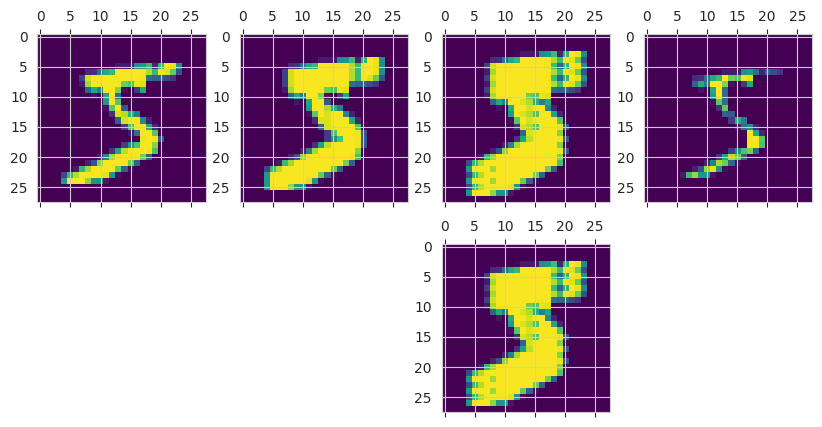

torch.Size([2048, 6, 28, 28]) torch.Size([2048, 6, 28, 28]) torch.Size([2048, 6, 28, 28])


In [98]:
import uuid


def compile_tropical_op(
        example_imgs: torch.Tensor,
        example_kernels: torch.Tensor,
        *,
        is_max: bool,
        block_size: int = 256,
        kernel_broadcasting: bool = False,
        debug: bool = False,
        fixed_stride: int = 1,
        fixed_padding: int = 1,
        fixed_dilation: int = 1,
        compile_entry_point: bool = True,
):
    # === Check example_imgs
    assert torch.cuda.is_available(), "No CUDA?"
    assert example_imgs.dtype == torch.float32, f"{example_imgs.dtype=}"
    assert example_kernels.dtype == torch.float32, f"{example_kernels.dtype=}"
    assert len(example_imgs.shape) == 4
    cs, i_ys, i_xs = example_imgs.shape[1:]

    # === Check example_kernels
    if len(example_kernels.shape) == 4:
        example_kernels = example_kernels.squeeze(1)
    k_cs, k_ys, k_xs = example_kernels.shape
    if kernel_broadcasting:
        assert k_cs == 1, f"Asked for kernel broadcasting, but {example_kernels.shape=}"
        raise NotImplementedError
    else:
        assert cs == k_cs, f"No kernel broadcasting, but {cs=} != {k_cs=}"

    # We reserve prov_maxval for debugging invalid provenances
    prov_maxval = np.iinfo(np.uint8).max
    assert k_ys < prov_maxval, f"Provenance indices are represented as u8, but {k_ys=}"
    assert k_xs < prov_maxval, f"Provenance indices are represented as u8, but {k_xs=}"

    ex_img_shape_no_b = tuple(example_imgs.shape[1:])
    ex_kernel_shape = tuple(example_kernels.shape)

    o_xs = _conv_output_size(i_xs, k_xs, fixed_stride, fixed_padding, fixed_dilation)
    o_ys = _conv_output_size(i_ys, k_ys, fixed_stride, fixed_padding, fixed_dilation)
    blocks_per_image = cs * o_xs * o_ys / block_size

    op_id = uuid.uuid4().hex
    # === (temporary) Forward functions ===
    if is_max:

        def weigh(v, w):
            return v + w

        neutral = -INF

        def select_right(left, right):
            return left < right

    else:

        def weigh(v, w):
            return v - w

        neutral = INF

        def select_right(left, right):
            return left > right

    # def is_valid(val):
    #     return val != neutral

    # === (temporary) Backward functions ===
    def one(_v, _w):
        return 1

    def minus_one(_v, _w):
        return -1

    if is_max:
        d_weigh_d_img = d_weigh_d_kernel = one
    else:
        d_weigh_d_img = one
        d_weigh_d_kernel = minus_one

    # === Compile user-provided functions
    weigh = cuda.jit(weigh, device=True, inline=True)
    select_right = cuda.jit(select_right, device=True, inline=True)
    d_weigh_d_img = cuda.jit(d_weigh_d_img, device=True, inline=True)
    d_weigh_d_kernel = cuda.jit(d_weigh_d_kernel, device=True, inline=True)

    # is_valid = cuda.jit(is_valid, device=True, inline=True)

    # === Forwards CUDA-side ===
    @cuda.jit(
        "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X
        " float32[:, :, :, :],"  # out_img: [Batch, Channel, Img_Y, Img_X]
        " uint8[:, :, :, :, :])",  # out_prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
        debug=debug,
        opt=not debug,
    )
    def conv_cuda_jit(img, kernel, out_img, out_prov):
        idx = cuda.grid(1)
        if idx >= out_img.size:
            return
        rem, o_x = divmod(idx, o_xs)
        rem, o_y = divmod(rem, o_ys)
        b, c = divmod(rem, cs)

        i_top_y = o_y * fixed_stride - fixed_padding
        i_left_x = o_x * fixed_stride - fixed_padding

        prov_x = prov_y = prov_maxval
        selected_val = neutral

        for k_y, i_y in enumerate(
                range(i_top_y, i_top_y + k_ys * fixed_dilation, fixed_dilation)
        ):
            for k_x, i_x in enumerate(
                    range(i_left_x, i_left_x + k_xs * fixed_dilation, fixed_dilation)
            ):
                if i_x < 0 or i_x >= i_xs or i_y < 0 or i_y >= i_ys:
                    continue

                img_val = img[b, c, i_y, i_x]
                kernel_val = kernel[0 if kernel_broadcasting else c, k_y, k_x]

                val = weigh(img_val, kernel_val)
                if select_right(selected_val, val):
                    selected_val = val
                    prov_y, prov_x = k_y, k_x

        out_img[b, c, o_y, o_x] = selected_val

        out_prov[b, c, o_y, o_x, 0] = prov_y
        out_prov[b, c, o_y, o_x, 1] = prov_x

    # === Forwards torch-side ===
    @torch.library.custom_op(
        f"semifields::tropical_op_{op_id}", mutates_args={}, device_types="cuda"
    )
    def conv_cuda_lib(
            img: torch.Tensor, kernel: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        img, kernel = img.detach(), kernel.detach()
        assert kernel.shape == ex_kernel_shape, f"Different {kernel.shape=}"
        assert img.shape[1:] == ex_img_shape_no_b, f"Different {img.shape[1:]=}"
        assert img.dtype == torch.float32, f"Wrong {img.dtype=}"
        if debug:
            print("Warning: running CUDA kernel in debug mode")
        batch = img.shape[0]
        out_img = img.new_empty((batch, cs, o_ys, o_xs))
        out_prov = img.new_empty((batch, cs, o_ys, o_xs, 2), dtype=torch.uint8)
        n_blocks = math.ceil(batch * blocks_per_image)
        conv_cuda_jit[n_blocks, block_size](img, kernel, out_img, out_prov)
        return out_img, out_prov

    @conv_cuda_lib.register_fake
    def _(img, kernel):
        batch = img.shape[0]
        return (
            img.new_empty((batch, cs, o_ys, o_xs)),
            kernel.new_empty((batch, cs, o_ys, o_xs, 2), dtype=torch.uint8),
        )

    # === Backwards CUDA-side ===
    # noinspection PyArgumentList
    @cuda.jit(
        "void(float32[:, :, :, :],"  # img: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :],"  # kernel: [Channel, Kernel_Y, Kernel_X]
        " float32[:, :, :, :],"  # tangent: [Batch, Channel, Img_Y, Img_X]
        " uint8[:, :, :, :, :],"  # prov: [Batch, Channel, Img_Y, Img_X, 2 (y, then x)]
        " float32[:, :, :, :],"  # out_img_grad: [Batch, Channel, Img_Y, Img_X]
        " float32[:, :, :])",  # out_kernel_grad: [Channel, Kernel_Y, Kernel_X]
        debug=debug,
        opt=not debug,
    )
    def conv_backwards_cuda_jit(
            img, kernel, gradient, prov, out_img_grad, out_kernel_grad
    ):
        idx = cuda.grid(1)
        if idx >= gradient.size:
            return
        rem, o_x = divmod(idx, o_xs)
        rem, o_y = divmod(rem, o_ys)
        b, c = divmod(rem, cs)
        gradient = gradient[b, c, o_y, o_x]
        if gradient == 0.0:
            return

        k_prov_y = prov[b, c, o_y, o_x, 0]
        k_prov_x = prov[b, c, o_y, o_x, 1]
        if k_prov_y == prov_maxval:
            # We only looked at padding values,
            # so our gradient can't be related to
            # the image
            return
        kernel_val = kernel[c, k_prov_y, k_prov_x]

        i_top_y = o_y * fixed_stride - fixed_padding
        i_left_x = o_x * fixed_stride - fixed_padding
        i_prov_y = i_top_y + fixed_dilation * k_prov_y
        i_prov_x = i_left_x + fixed_dilation * k_prov_x
        if i_prov_x < 0 or i_prov_x >= i_xs or i_prov_y < 0 or i_prov_y >= i_ys:
            return
        img_val = img[b, c, i_prov_y, i_prov_x]

        dv = d_weigh_d_img(img_val, kernel_val) * gradient
        dw = d_weigh_d_kernel(img_val, kernel_val) * gradient

        cuda.atomic.add(out_img_grad, (b, c, i_prov_y, i_prov_x), dv)
        cuda.atomic.add(out_kernel_grad, (c, k_prov_y, k_prov_x), dw)

    # === Backwards torch-side ===
    @torch.library.custom_op(
        f"semifields::tropical_op_back_{op_id}", mutates_args={}, device_types="cuda"
    )
    def conv_backwards_cuda_lib(
            img: torch.Tensor,
            kernel: torch.Tensor,
            gradient: torch.Tensor,
            prov: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        img, kernel = img.detach(), kernel.detach()
        out_img_grad = torch.zeros_like(img)
        out_kernel_grad = torch.zeros_like(kernel)
        n_blocks = math.ceil(gradient.nelement() / block_size)
        conv_backwards_cuda_jit[n_blocks, block_size](
            img, kernel, gradient, prov, out_img_grad, out_kernel_grad
        )
        return out_img_grad, out_kernel_grad

    @conv_backwards_cuda_lib.register_fake
    def _(img, kernel, _gradient, _prov):
        return torch.empty_like(img), torch.empty_like(kernel)

    def back_setup(ctx, inputs, output):
        img, kernel = inputs
        _out_img, prov = output
        ctx.img = img
        ctx.kernel = kernel
        ctx.prov = prov

    def lib_back(ctx, grad_output, _grad_prov):
        return conv_backwards_cuda_lib(ctx.img, ctx.kernel, grad_output, ctx.prov)

    conv_cuda_lib.register_autograd(lib_back, setup_context=back_setup)

    if debug:
        print("Calculated output shape", cs, o_ys, o_xs)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            with torch.autograd.detect_anomaly():
                # noinspection PyTypeChecker
                torch.library.opcheck(conv_cuda_lib, (example_imgs, example_kernels))
    del example_imgs, example_kernels

    # === Entry point ===
    @torch.compile(fullgraph=True, backend="inductor", disable=not compile_entry_point)
    def conv(
            img: torch.Tensor,
            kernel: torch.Tensor,
            stride: int = fixed_stride,
            padding: int = fixed_padding,
            dilation: int = fixed_dilation,
    ):
        if len(kernel.shape) == 4:
            kernel = kernel.squeeze(1)

        if (
                padding != fixed_padding
                or stride != fixed_stride
                or dilation != fixed_dilation
        ):
            raise ValueError("Cannot change stride/padding/dilation after compilation")

        out_img, _out_prov = conv_cuda_lib(img, kernel)
        return out_img

    return conv


torch.cuda.empty_cache()
ex_op = compile_tropical_op(g_imgs, g_kernels, is_max=True, debug=True)
ex_op_modified = compile_tropical_op(
    g_imgs,
    g_kernels,
    debug=True,
    is_max=True,
    fixed_stride=1,
    fixed_padding=2,
    fixed_dilation=2,
)
ex_min_op = compile_tropical_op(test_imgs, test_kernels, is_max=False, debug=True)
ex_res = ex_op(g_imgs, g_kernels)
ex_res_mod = ex_op_modified(g_imgs, g_kernels)
ex_res_min = ex_min_op(g_imgs, g_kernels)

ref_res = convolutions.TropicalConv2D(is_max=True)(
    test_imgs, test_kernels.unsqueeze(1), stride=1, padding=2, dilation=2
)

_, (axs, axs_ref) = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
axs[0].matshow(test_imgs[0, 1].numpy(force=True))
axs[1].matshow(ex_res[0, 1].numpy(force=True))
axs[2].matshow(ex_res_mod[0, 1].numpy(force=True))
axs[3].matshow(ex_res_min[0, 1].numpy(force=True))

axs_ref[0].axis("off")
axs_ref[1].axis("off")
axs_ref[2].matshow(ref_res[0, 1].numpy(force=True))
axs_ref[3].axis("off")
plt.show()
print(test_imgs.shape, ex_res.shape, ex_res_mod.shape)

In [99]:
def visualise_gradient(
        conv_op,
        img_nr: int = 0,
        channel: int = 4,
        tangent_xs=(7, 7, 7, 8),
        tangent_ys=(6, 7, 8, 6),
        **conv_kwargs,
):
    imgs = test_imgs.clone()
    kernel = test_kernels.clone()
    imgs.requires_grad_(True)
    kernel.requires_grad_(True)
    imgs.grad = None
    kernel.grad = None

    convolved = conv_op(imgs, kernel.unsqueeze(1), **conv_kwargs)
    convolved[img_nr, channel, tangent_ys, tangent_xs].sum().backward()
    _, axs = plt.subplots(ncols=5, layout="compressed", figsize=(15, 15), dpi=300)
    axs[0].matshow(kernel[channel].numpy(force=True))
    axs[0].set_title("Kernel")
    axs[1].matshow(
        imgs[img_nr, channel, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
    )
    axs[1].set_title("Original")
    axs[2].matshow(
        convolved[img_nr, channel, y_slice, x_slice].numpy(force=True), vmin=0, vmax=2
    )
    axs[2].set_title("Convolved")
    imgs_grad = imgs.grad[img_nr, channel, y_slice, x_slice].numpy(force=True)
    axs[3].matshow(imgs_grad)
    axs[3].set_title("Image Gradient")
    kernel_grad = kernel.grad[channel].numpy(force=True)
    axs[4].matshow(kernel_grad)
    axs[4].set_title("Kernel Gradient")
    for grad_y, grad_x in zip(*imgs_grad.nonzero()):
        axs[3].text(
            grad_x,
            grad_y,
            imgs_grad[grad_y, grad_x],
            color="black",
            fontsize=5,
            ha="center",
            va="center",
        )
    for grad_y, grad_x in zip(*kernel_grad.nonzero()):
        axs[4].text(
            grad_x,
            grad_y,
            kernel_grad[grad_y, grad_x],
            color="black",
            fontsize=10,
            ha="center",
            va="center",
        )
    for ax, values in zip(axs[1:4], (imgs, convolved, imgs.grad)):
        for t_x, t_y in zip(tangent_xs, tangent_ys):
            ax.text(
                t_x,
                t_y,
                values[img_nr, channel, t_y, t_x].numpy(force=True).round(2),
                color="red",
                fontsize=5,
                ha="center",
                va="center",
            )
        # ax.scatter(target_x, target_y, marker="x", color='red')
    plt.suptitle("Unfold-max gradients")
    print("Nonzero gradient in image:", imgs_grad.nonzero())

Nonzero gradient in image: (array([7, 8]), array([8, 8]))


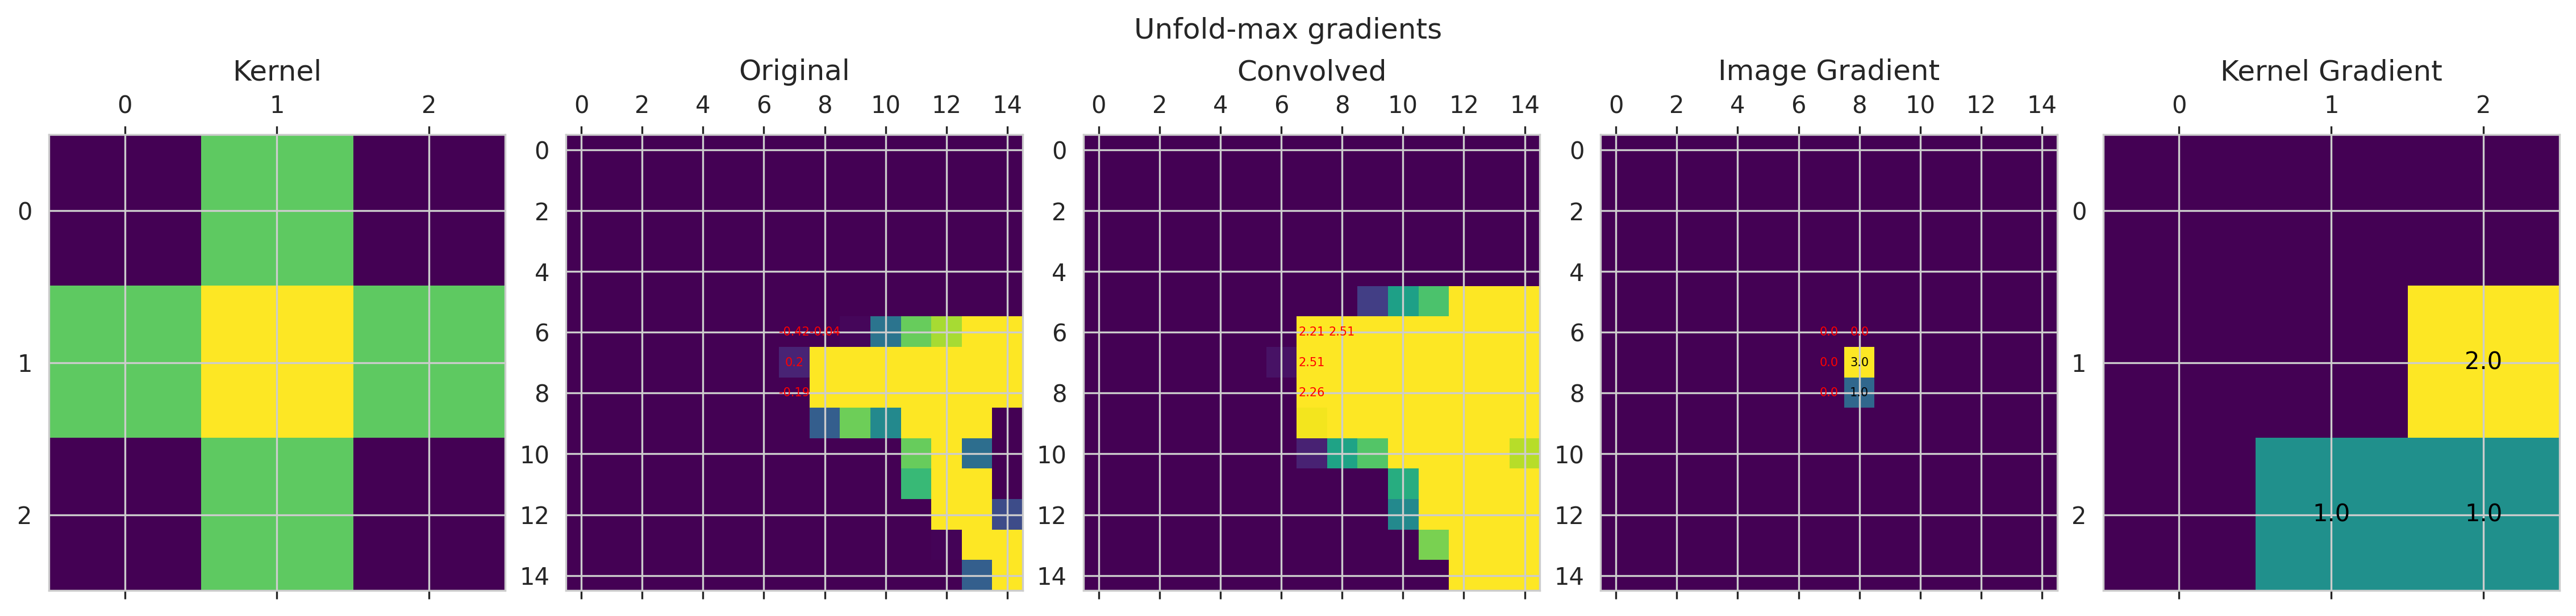

In [100]:
visualise_gradient(ex_op)

Nonzero gradient in image: (array([7, 8, 8]), array([ 9,  9, 10]))


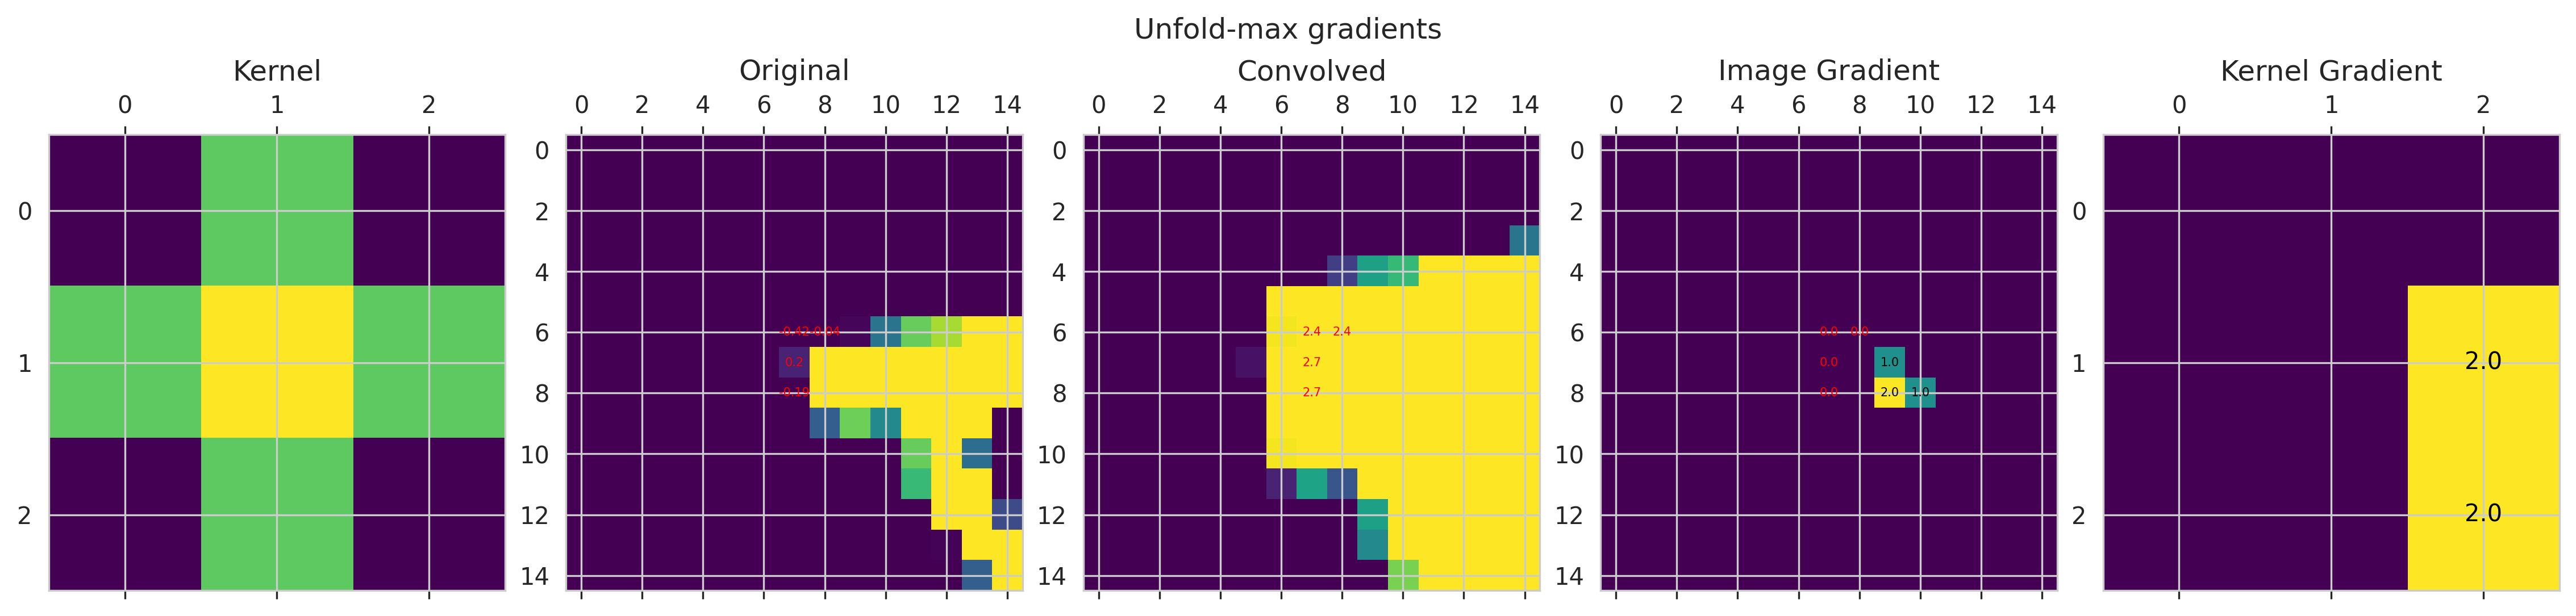

In [101]:
visualise_gradient(ex_op_modified)

In [102]:
import warnings

failed1 = failed2 = None


def test_same_conv(conv1, conv2, dilation=1, padding=1, stride=1):
    global failed1, failed2
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        with torch.autograd.detect_anomaly():
            imgs1, kernels1 = (
                test_imgs.clone().requires_grad_(True),
                test_kernels.clone().unsqueeze(1).requires_grad_(True),
            )
            imgs2, kernels2 = (
                test_imgs.clone().requires_grad_(True),
                test_kernels.clone().unsqueeze(1).requires_grad_(True),
            )

            res1 = conv1(
                imgs1, kernels1, dilation=dilation, padding=padding, stride=stride
            )
            res2 = conv2(
                imgs2, kernels2, dilation=dilation, padding=padding, stride=stride
            )
            failed1, failed2 = res1, res2
            torch.testing.assert_close(
                res1.detach(), res2.detach(), msg="Results are not equal"
            )

            tangent = torch.randn_like(res1)
            res1.backward(tangent)
            res2.backward(tangent)
            failed1, failed2 = imgs1, imgs2
            torch.testing.assert_close(
                imgs1.detach(), imgs2.detach(), msg="Images were mutated"
            )
            failed1, failed2 = kernels1, kernels2

            torch.testing.assert_close(
                kernels1.detach(), kernels2.detach(), msg="Kernels were mutated"
            )
            failed1, failed2 = imgs1.grad.clone(), imgs2.grad.clone()
            torch.testing.assert_close(
                imgs1.grad, imgs2.grad, msg="Image gradient differs"
            )
            failed1, failed2 = kernels1.grad.clone(), kernels2.grad.clone()
            # More generous with kernel grad, because it is the result of a large reduction (errors compound)
            torch.testing.assert_close(
                kernels1.grad,
                kernels2.grad,
                msg="Kernel gradient differs",
                atol=0.01,
                rtol=0.01,
            )
            failed1 = failed2 = None


# Simple sanity checks
test_same_conv(convolutions.TropicalConv2D(is_max=True), ex_op)
print("Unfold max same as Numba CUDA version")
test_same_conv(convolutions.TropicalConv2D(is_max=False), ex_min_op)
print("Unfold min same as Numba CUDA version")
test_same_conv(
    convolutions.TropicalConv2D(is_max=True), ex_op_modified, padding=2, dilation=2
)
print("Modified max same as Numba CUDA version")
print("OK")

Unfold max same as Numba CUDA version
Unfold min same as Numba CUDA version
Modified max same as Numba CUDA version
OK


In [103]:
import itertools


def check_param_space(max_stride: int = 5, max_padding: int = 5, max_dilation: int = 5):
    torch.manual_seed(0)
    param_space = itertools.product(
        (False, True),
        range(1, max_stride + 1),
        range(max_padding + 1),
        range(1, max_dilation + 1),
    )

    bar = tqdm(param_space, total=2 * max_stride * (max_padding + 1) * max_dilation)
    for is_max, stride, padding, dilation in bar:
        bar.set_postfix(
            is_max=is_max,
            stride=stride,
            padding=padding,
            dilation=dilation,
            refresh=True,
        )
        test_same_conv(
            convolutions.TropicalConv2D(is_max=is_max),
            compile_tropical_op(
                test_imgs,
                test_kernels,
                is_max=is_max,
                fixed_stride=stride,
                fixed_padding=padding,
                fixed_dilation=dilation,
                compile_entry_point=False,
                debug=False,
            ),
            stride=stride,
            padding=padding,
            dilation=dilation,
        )
    print("OK")


check_param_space()

  0%|          | 0/300 [00:00<?, ?it/s]

OK


In [104]:
if failed1 is not None:
    _, axs = plt.subplots(ncols=4, layout="compressed", figsize=(10, 6))
    channel_nr = 0
    img_num = 0
    axs[0].matshow(test_kernels[channel_nr].numpy(force=True))
    axs[0].set_title("Kernel")
    axs[1].matshow(failed1[img_num, channel_nr, -5:, -5:].numpy(force=True))
    axs[1].set_title("Unpool")
    axs[2].matshow(failed2[img_num, channel_nr, -5:, -5:].numpy(force=True))
    axs[2].set_title("Numba")
    diff = (failed1[:, channel_nr] - failed2[:, channel_nr]).numpy(force=True).round(2)
    print("Channel failed: ", diff.any())
    axs[3].matshow(diff[img_num, -5:, -5:])
    axs[3].set_title("Unpool $-$ Numba")
    plt.show()

Nonzero gradient in image: (array([7, 8, 8]), array([ 9,  9, 10]))


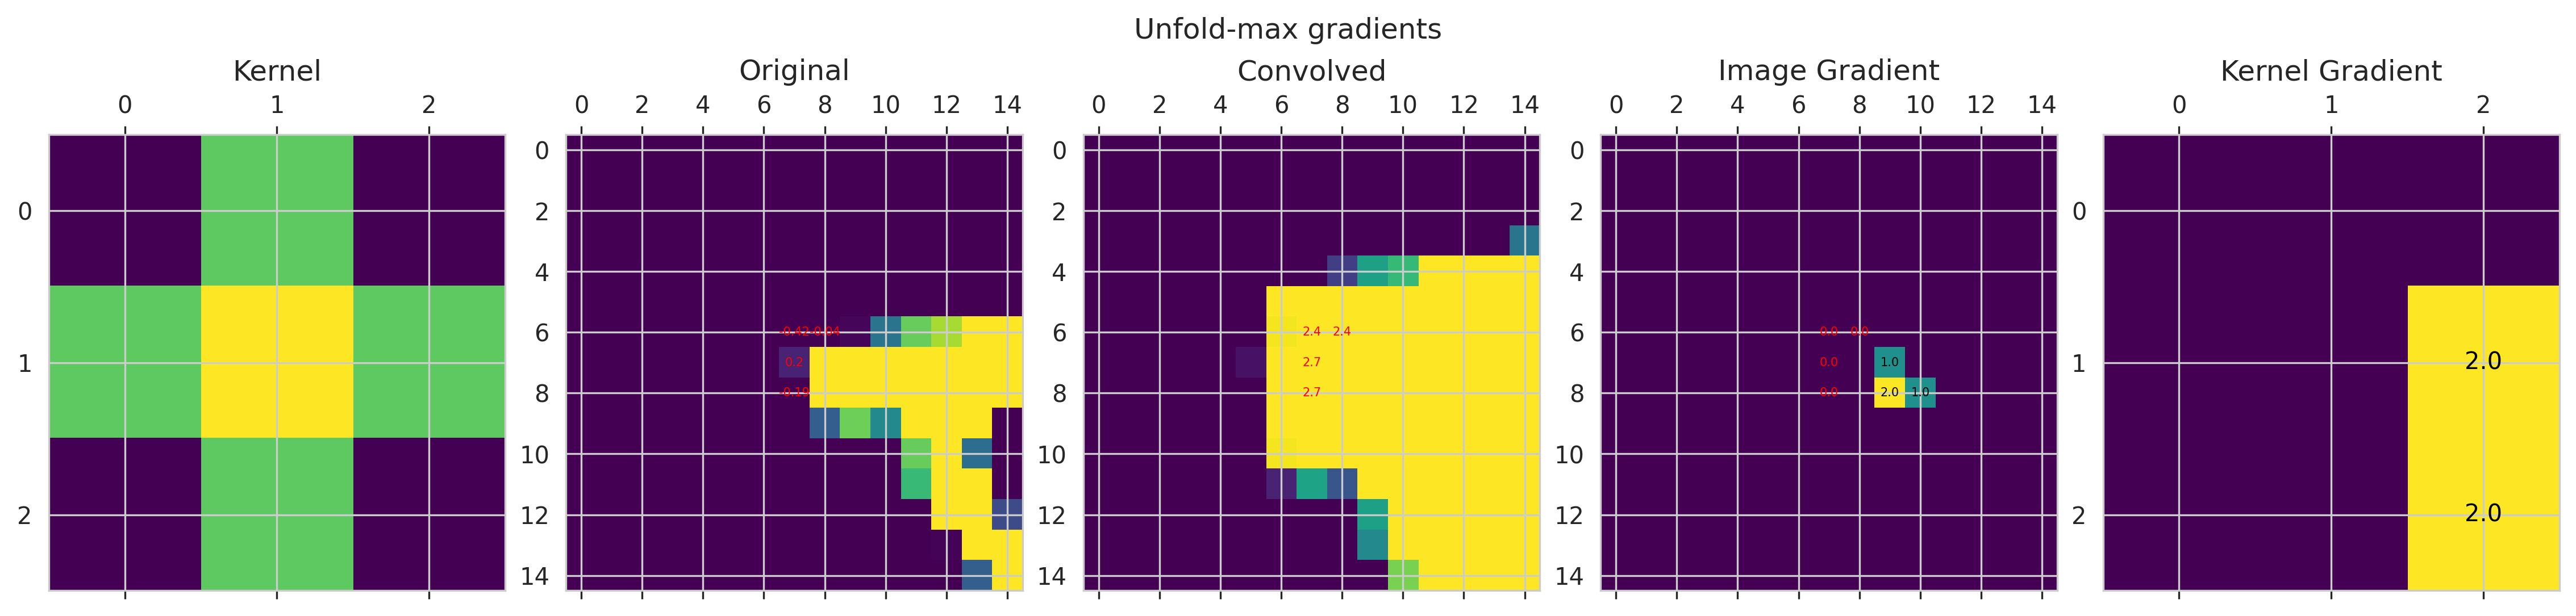

In [105]:
visualise_gradient(ex_op_modified, padding=2, dilation=2)

In [106]:
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
g_imgs.requires_grad_(True)
g_kernels.requires_grad_(True)
timing_op = compile_tropical_op(
    g_imgs, g_kernels, is_max=True, fixed_stride=4, compile_entry_point=False
)
timing_tangent = torch.randn_like(timing_op(g_imgs, g_kernels))


def run_one():
    torch.cuda.synchronize()
    arr = timing_op(g_imgs, g_kernels.unsqueeze(1), padding=1)
    arr.backward(timing_tangent)
    del arr
    torch.cuda.synchronize()


torch.cuda.empty_cache()
run_one()
%timeit run_one()
torch.cuda.empty_cache()

694 μs ± 392 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [107]:
g_imgs = test_imgs.clone()
g_kernels = test_kernels.clone()
g_imgs.requires_grad_(True)
g_kernels.requires_grad_(True)
timing_op = convolutions.TropicalConv2D(is_max=True)
timing_tangent_alt = torch.randn_like(
    timing_op(g_imgs, g_kernels.unsqueeze(1), padding=1, stride=1)
)


def run_one():
    torch.cuda.synchronize()
    arr = timing_op(g_imgs, g_kernels.unsqueeze(1), padding=1, stride=1)
    arr.backward(timing_tangent_alt)
    del arr
    torch.cuda.synchronize()


torch.cuda.empty_cache()
run_one()
%timeit run_one()
torch.cuda.empty_cache()

16.3 ms ± 4.11 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [108]:
# fmt: off
slice_sizes_strided = [2, 3, 4, 6, 8, 12, 16, 23, 32, 46, 64, 91, 128, 182, 256, 363, 512, 725, 1024, 1449, 2048]
unfold_timings_strided = [8.601449850539211e-05, 8.685274399613263e-05, 8.811392699863064e-05, 9.129133899841691e-05,
                          9.529797050345224e-05, 0.00010843907199887326, 0.0001297704460012028, 0.0001692897860048106,
                          0.0002150408624947886, 0.0002577364699973259, 0.0003326715309958672, 0.0004528659589996096,
                          0.0006127196800007369, 0.0008511361700002453, 0.0011737010774959345, 0.0016564025280022179,
                          0.002323884569996153, 0.004694061680500454, 0.00660860281749774, 0.009336203852995823,
                          0.013332939886495296]
numba_timings_strided = [0.00041195699350646465, 0.00040493240950308974, 0.00042407115850073753, 0.0004106013964992599,
                         0.00041579102399555266, 0.0004095743720026803, 0.0004096275139963836, 0.0004132225249995827,
                         0.0004206770234959549, 0.000413780028000474, 0.00042235061099927406, 0.0004335881020015222,
                         0.000461321377006243, 0.0004885255344997859, 0.0005262560795017635, 0.0005949012644996401,
                         0.0006804647999961162, 0.0008060576959978789, 0.0009685207395014004, 0.001236962188500911,
                         0.0017974001669936114]
# fmt: on

In [109]:
run_timings_strided = False
time_stride_size = 2

In [116]:
def get_timings_comparison(
        n_loops: int = 2_000,
        kernel: torch.Tensor = test_kernels,
        stride: int = 1,
        dilation: int = 1,
        padding: int = 0,
):
    code = f"""
sync()
arr = dilate(imgs, kernel, padding={padding}, stride={stride}, dilation={dilation})
arr.backward(gradient)
del arr
sync() """
    sizes = []
    unfold_times = []
    numba_times = []
    bar = trange(2, 23)
    for log_size in bar:
        size = math.ceil(2 ** (log_size / 2))
        batch = test_imgs[:size].clone().requires_grad_(True)
        sizes.append(len(batch))
        if len(kernel.shape) == 3:
            kernel = kernel.unsqueeze(1)
        kernel = kernel.clone().requires_grad_(True)
        op = compile_tropical_op(
            batch,
            kernel,
            is_max=True,
            fixed_stride=stride,
            fixed_padding=padding,
            fixed_dilation=dilation,
            compile_entry_point=False,
        )
        gradient = torch.randn_like(op(batch, kernel))
        unfold_times.append(
            timeit(
                code,
                number=n_loops,
                globals={
                    "sync": torch.cuda.synchronize,
                    "imgs": batch,
                    "kernel": kernel,
                    "gradient": gradient,
                    "dilate": unfold_max,
                },
            )
            / n_loops
        )
        numba_times.append(
            timeit(
                code,
                number=n_loops,
                globals={
                    "sync": cuda.synchronize,
                    "imgs": batch,
                    "kernel": kernel,
                    "gradient": gradient,
                    "dilate": op,
                },
            )
            / n_loops
        )
        bar.set_postfix(
            size=sizes[-1],
            faster="unfold" if unfold_times[-1] < numba_times[-1] else "numba",
        )
    return sizes, unfold_times, numba_times

In [118]:
def plot_timings_comparison(sizes, unfold_times, numba_times, title=""):
    basic_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    plt.plot(sizes, unfold_times, label="Unfold", color=basic_colors[0])
    plt.scatter(sizes, unfold_times, color=basic_colors[0])
    plt.plot(sizes, numba_times, label="Numba CUDA", color=basic_colors[1])
    plt.scatter(sizes, numba_times, color=basic_colors[1])
    numba_better_from = (np.subtract(unfold_times, numba_times) > 0).argmax()
    plt.axvline(sizes[numba_better_from], linestyle="dashed", color="grey")
    plt.text(
        sizes[numba_better_from - 1],
        10 ** -3,
        sizes[numba_better_from],
        color="grey",
    )
    adj_numba = np.asarray(numba_times) - numba_times[1] + unfold_times[1]
    plt.plot(
        sizes,
        adj_numba,
        label="Theoretical no-overhead Numba",
        linestyle="dashed",
        color=basic_colors[1],
    )
    plt.xlabel("Batch size")
    plt.ylabel("Time")
    plt.title(title)
    plt.loglog()
    plt.legend()
    plt.show()

  0%|          | 0/21 [00:00<?, ?it/s]

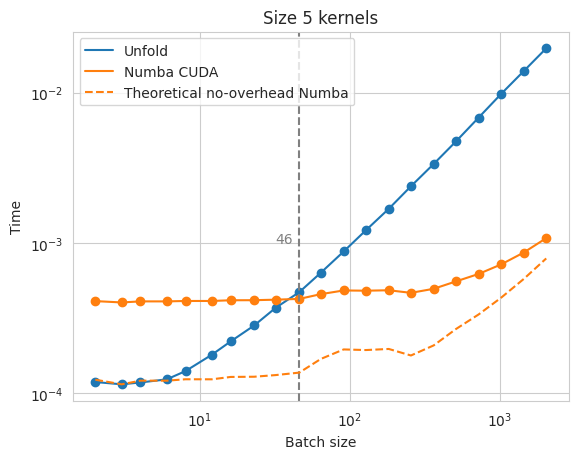

In [120]:
plot_timings_comparison(
    *get_timings_comparison(
        kernel=torch.randn(6, 1, 5, 5, device="cuda"), padding=2, stride=2
    ),
    title="Size 5 kernels",
)

  0%|          | 0/21 [00:00<?, ?it/s]

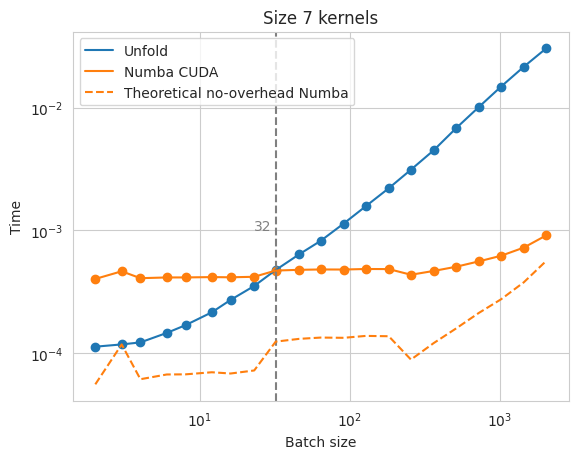

In [121]:
plot_timings_comparison(
    *get_timings_comparison(
        kernel=torch.randn(6, 1, 7, 7, device="cuda"), padding=2, stride=2
    ),
    title="Size 7 kernels",
)

In [110]:
if run_timings_strided:
    torch_code = f"""
sync()
arr = dilate(imgs, kernels, padding=1, stride={time_stride_size})
arr.backward(tangent)
del arr
sync()
    """
    slice_sizes_strided = []
    unfold_timings_strided = []
    numba_timings_strided = []
    num_loops = 2_000
    bar = trange(2, 23)
    for size_pow in bar:
        test_size = math.ceil(2 ** (size_pow / 2))
        test_slice = test_imgs[:test_size]
        slice_sizes_strided.append(len(test_slice))
        timing_op = compile_tropical_op(
            test_slice,
            test_kernels,
            is_max=True,
            fixed_stride=time_stride_size,
            compile_entry_point=False,
        )
        _test_out = timing_op(test_slice, test_kernels)
        test_tangent = torch.randn_like(_test_out)
        unfold_timings_strided.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": torch.cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.unsqueeze(1).clone().requires_grad_(True),
                    "tangent": test_tangent,
                    "dilate": unfold_max,
                },
            )
            / num_loops
        )
        numba_timings_strided.append(
            timeit(
                torch_code,
                number=num_loops,
                globals={
                    "sync": cuda.synchronize,
                    "imgs": test_slice.clone().requires_grad_(True),
                    "kernels": test_kernels.clone().requires_grad_(True),
                    "tangent": test_tangent,
                    "dilate": timing_op,
                },
            )
            / num_loops
        )
        bar.set_postfix(
            size=slice_sizes_strided[-1],
            faster="unfold"
            if unfold_timings_strided[-1] < numba_timings_strided[-1]
            else "numba",
        )

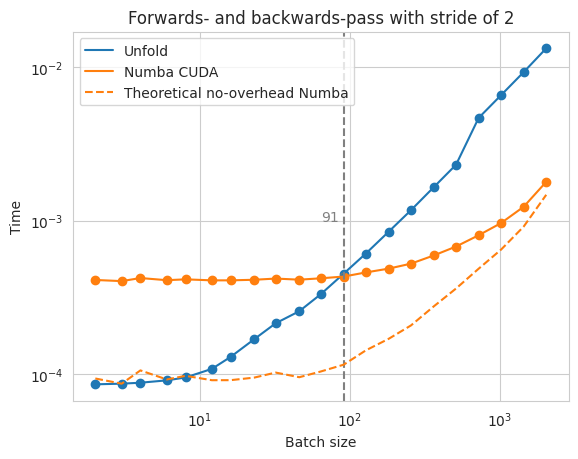

In [111]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.plot(slice_sizes_strided, unfold_timings_strided, label="Unfold", color=colors[0])
plt.scatter(slice_sizes_strided, unfold_timings_strided, color=colors[0])
plt.plot(
    slice_sizes_strided, numba_timings_strided, label="Numba CUDA", color=colors[1]
)
plt.scatter(slice_sizes_strided, numba_timings_strided, color=colors[1])
first_better = (np.subtract(unfold_timings_strided, numba_timings_strided) > 0).argmax()
plt.axvline(slice_sizes_strided[first_better], linestyle="dashed", color="grey")
plt.text(
    slice_sizes_strided[first_better - 1],
    10 ** -3,
    slice_sizes_strided[first_better],
    color="grey",
)
adjusted_numba = (
        np.asarray(numba_timings_strided)
        - numba_timings_strided[1]
        + unfold_timings_strided[1]
)
plt.plot(
    slice_sizes_strided,
    adjusted_numba,
    label="Theoretical no-overhead Numba",
    linestyle="dashed",
    color=colors[1],
)
plt.xlabel("Batch size")
plt.ylabel("Time")
plt.title(f"Forwards- and backwards-pass with stride of {time_stride_size}")
plt.loglog()
plt.legend()
plt.show()

In [156]:
import importlib
from src import convolutions
from src.convolutions import cuda_select

importlib.reload(cuda_select)
importlib.reload(convolutions)
from src import convolutions

In [157]:
test_kernels.shape

torch.Size([6, 3, 3])

In [158]:
ss_max = convolutions.SelectSemifield.tropical_max().compile(
    test_imgs, test_kernels.unsqueeze(1), groups=6, debug=True
)
ss_max

Calculated output shape 6 28 28


<function src.convolutions.cuda_select._entrypoint.<locals>.conv(img: 'torch.Tensor', kernel: 'torch.Tensor', stride: 'int' = 1, padding: 'int' = 1, dilation: 'int' = 1, groups: 'int' = 6)>

Nonzero gradient in image: (array([7, 8]), array([8, 8]))


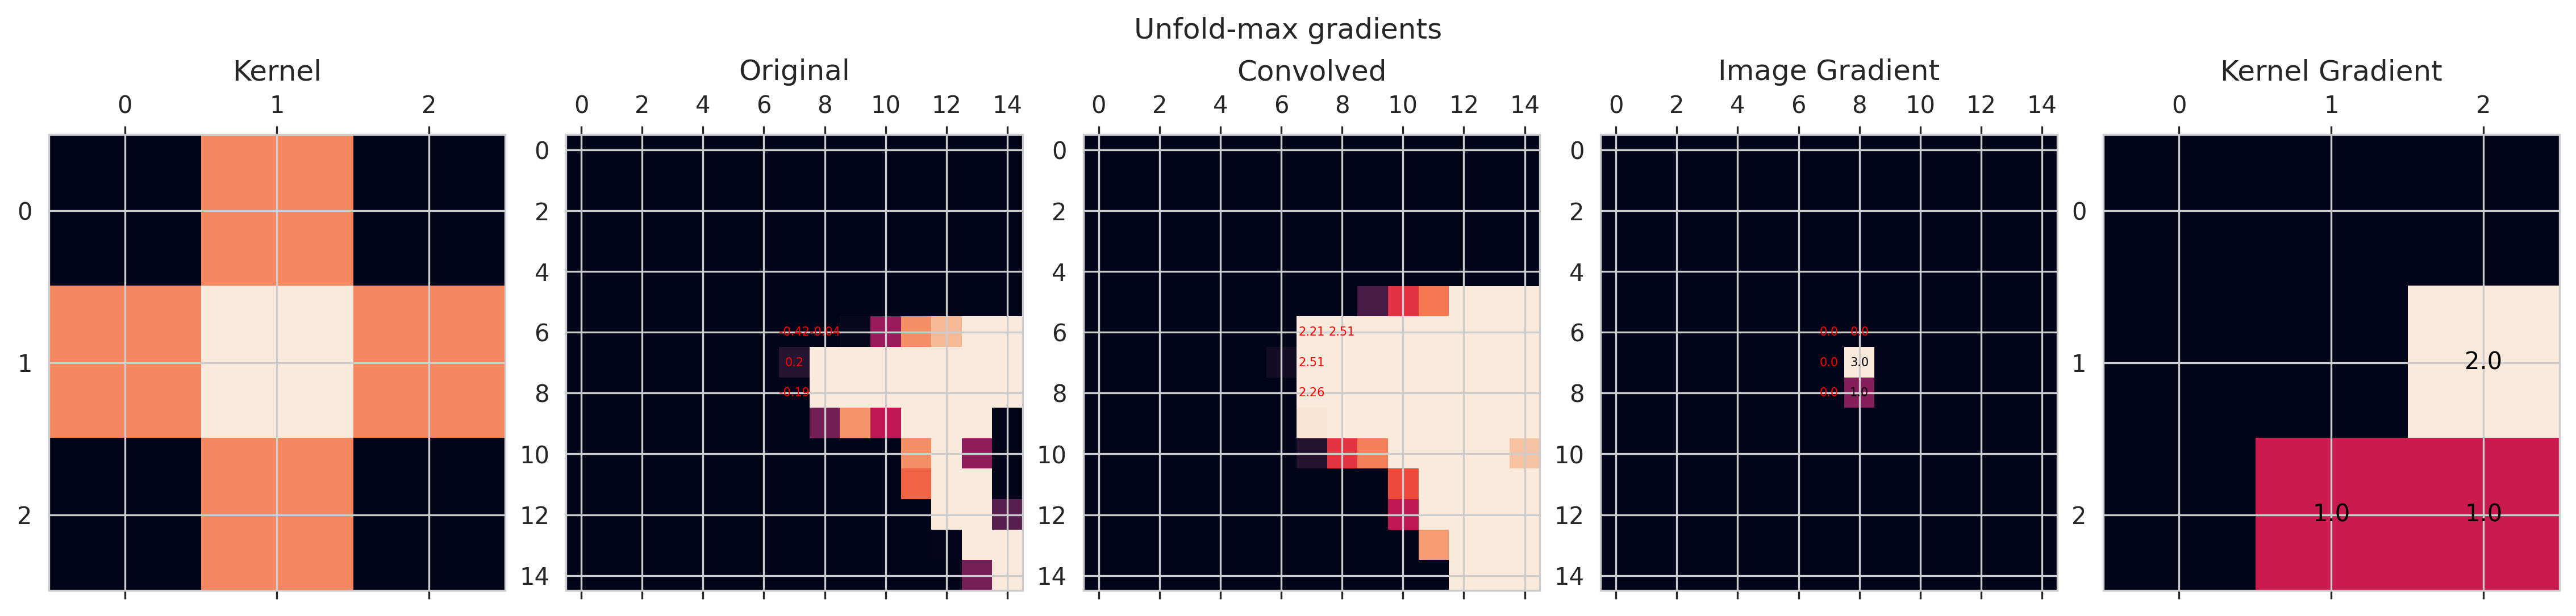

In [159]:
visualise_gradient(
    ss_max,
)

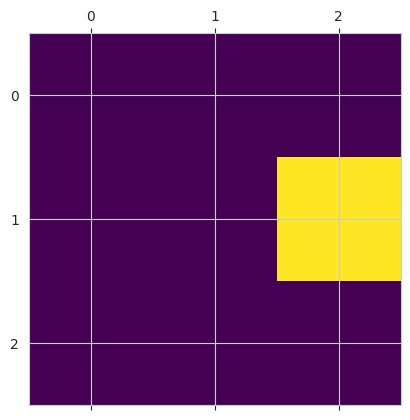

In [112]:
# Alternate form: less work, but can't be traced!


class TestMaxOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, img: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
        res, prov = max_op(img, kernel)
        ctx.save_for_backward(img, kernel, prov)
        return res

    # noinspection PyMethodOverriding
    @staticmethod
    def backward(ctx, grad_output: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        img, kernel, prov = ctx.saved_tensors
        return max_back_op(img, kernel, grad_output, prov)


g_kernels.grad = None
g_kernels.requires_grad_(True)
TestMaxOp.apply(test_imgs, g_kernels).backward(test_tangent)
plt.matshow(g_kernels.grad[channel_nr].numpy(force=True))